<a href="https://colab.research.google.com/github/rifahtasnia/Air-Canada-Seat-choice-prediction/blob/master/Air_Canada_With_Down_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


# Dataset Loading

In [ ]:
participant_data_path = "/content/participant_data.csv"

p_data = pd.read_csv(participant_data_path)

p_data_preview = p_data.head()
p_data_preview

,id,ticket_id,od,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
0,0,4157258036156055,BBBDDD,2024-01-01 03:00,2023-07-23 15:08,0,2,3,48,86,50,10,50,10,NaN
1,1,"7,18E+15",BBBDDD,2024-01-01 03:00,2023-07-26 11:44,1,2,1,37,82,50,10,50,7,NaN
2,2,3353015593651433,BBBDDD,2024-01-01 03:00,2023-08-03 06:03,0,1,2,35,80,50,10,50,7,pref
3,3,5763957877920625,BBBDDD,2024-01-01 03:00,2023-08-13 17:41,0,3,1,36,68,50,10,50,5,nochoice
4,4,1095418927576125,BBBDDD,2024-01-01 03:00,2023-08-20 22:04,0,3,1,57,70,50,10,50,5,pref


# Feature Extraction

In [ ]:
participant_data = p_data[p_data['choice'].notnull()]

participant_data['flight_departure_datetime'] = pd.to_datetime(participant_data['flight_departure_datetime'], errors='coerce')
participant_data['purchase_datetime'] = pd.to_datetime(participant_data['purchase_datetime'], errors='coerce')


participant_data['departure_month'] = participant_data['flight_departure_datetime'].dt.strftime('%y%m').astype(int)
participant_data['purchase_month'] = participant_data['purchase_datetime'].dt.strftime('%y%m').astype(int)

# Inventory ratios
participant_data['advs_inventory_ratio'] = participant_data['ADVS_inventory'] / participant_data['ADVS_capacity']
participant_data['pref_inventory_ratio'] = participant_data['PREF_inventory'] / participant_data['PREF_capacity']

# Total inventory ratio (sum of both)
participant_data['total_inventory_ratio'] = participant_data['advs_inventory_ratio'] + participant_data['pref_inventory_ratio']

# Choice mapping
choice_mapping = {'advs': 1, 'pref': 2, 'nochoice': 0}
participant_data['choice_map'] = participant_data['choice'].map(choice_mapping).astype(int)

# Day of the week for departure
participant_data['dep_dow_id'] = participant_data['flight_departure_datetime'].dt.dayofweek

# Weeks before departure
participant_data['purchweeks_before_depart'] = ((participant_data['flight_departure_datetime'] - participant_data['purchase_datetime']).dt.days / 7).astype(int)


extracted_features = participant_data[['departure_month', 'purchase_month', 'trip_type', 'branded_fare', 'number_of_pax',
                                       'ADVS_price', 'PREF_price', 'ADVS_capacity', 'PREF_capacity', 'advs_inventory_ratio',
                                       'pref_inventory_ratio', 'total_inventory_ratio', 'choice', 'choice_map', 'dep_dow_id',
                                       'purchweeks_before_depart']]

extracted_features.head(5)

<ipython-input-33-1d2f0b93b86f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_data['flight_departure_datetime'] = pd.to_datetime(participant_data['flight_departure_datetime'], errors='coerce')
<ipython-input-33-1d2f0b93b86f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_data['purchase_datetime'] = pd.to_datetime(participant_data['purchase_datetime'], errors='coerce')
<ipython-input-33-1d2f0b93b86f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,departure_month,purchase_month,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,advs_inventory_ratio,pref_inventory_ratio,total_inventory_ratio,choice,choice_map,dep_dow_id,purchweeks_before_depart
2,2401,2308,0,1,2,35,80,50,10,1.00,0.7,1.70,pref,2,0,21
3,2401,2308,0,3,1,36,68,50,10,1.00,0.5,1.50,nochoice,0,0,20
4,2401,2308,0,3,1,57,70,50,10,1.00,0.5,1.50,pref,2,0,19
7,2401,2309,1,3,1,41,76,50,10,0.96,0.4,1.36,pref,2,0,15
8,2401,2309,1,0,3,44,81,50,10,0.96,0.3,1.26,nochoice,0,0,14
10,2401,2309,0,1,1,38,81,50,10,0.96,0.0,0.96,advs,1,0,13
12,2401,2310,0,0,1,44,75,50,10,0.94,0.0,0.94,advs,1,0,10
13,2401,2310,0,1,1,38,73,50,10,0.92,0.0,0.92,nochoice,0,0,10
14,2401,2310,0,0,2,43,81,50,10,0.92,0.0,0.92,nochoice,0,0,9
15,2401,2311,0,1,1,25,76,50,10,0.92,0.0,0.92,nochoice,0,0,7


In [ ]:
# Display the count of each class in the balanced dataset
class_counts = extracted_features['choice_map'].value_counts()
class_counts

,count
choice_map,
0,130886
1,33331
2,28281


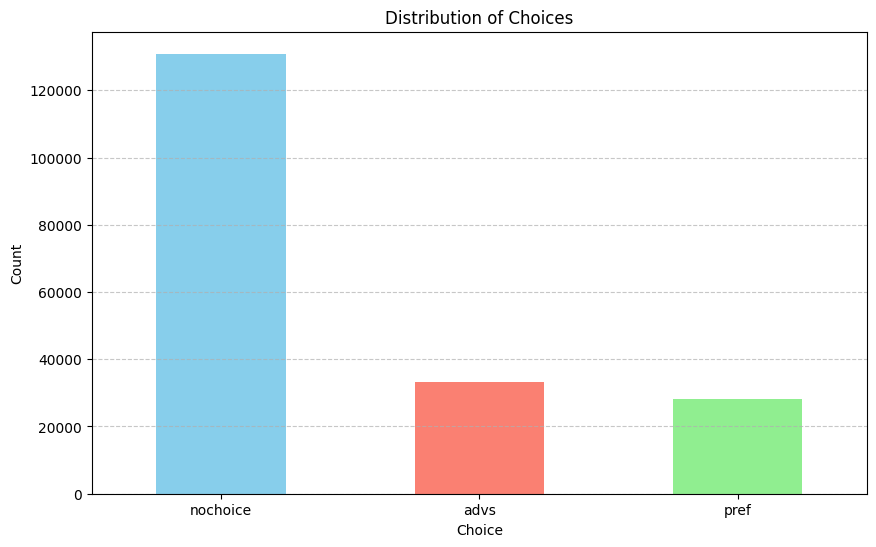

In [ ]:
choice_distribution = extracted_features['choice'].value_counts()

plt.figure(figsize=(10, 6))
choice_distribution.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Choices')
plt.xlabel('Choice')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Perform under-sampling to balance the dataset

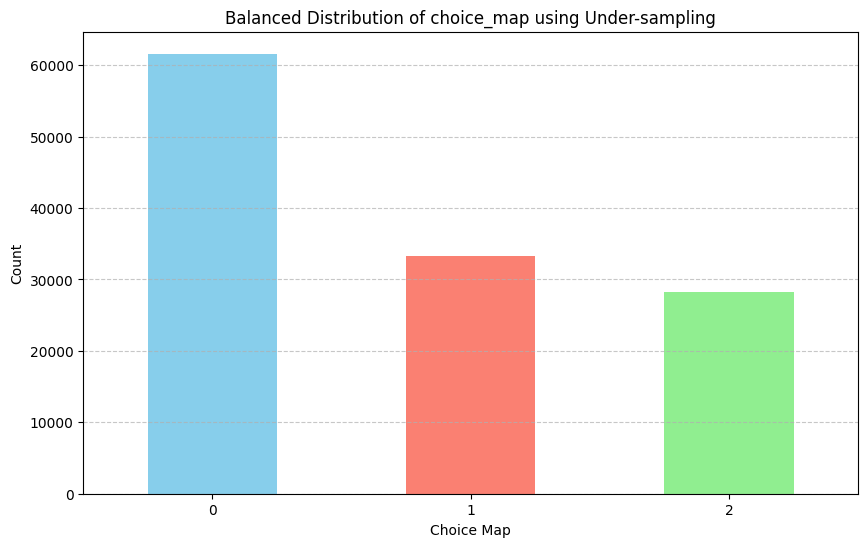

In [ ]:
X = extracted_features.drop(['choice', 'choice_map'], axis=1)
y = extracted_features['choice_map']

data_combined = pd.concat([X, y], axis=1)


majority_class = data_combined[data_combined['choice_map'] == data_combined['choice_map'].value_counts().idxmax()]
minority_classes = data_combined[data_combined['choice_map'] != data_combined['choice_map'].value_counts().idxmax()]


majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_classes),
                                random_state=42)


balanced_data = pd.concat([majority_downsampled, minority_classes])


balanced_distribution_under = balanced_data['choice_map'].value_counts()


plt.figure(figsize=(10, 6))
balanced_distribution_under.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Balanced Distribution of choice_map using Under-sampling')
plt.xlabel('Choice Map')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
balanced_data.head()

,departure_month,purchase_month,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,advs_inventory_ratio,pref_inventory_ratio,total_inventory_ratio,dep_dow_id,purchweeks_before_depart,choice_map
41173,2402,2401,0,1,3,48,110,250,50,0.924000,0.540000,1.464000,2,5,0
177286,2409,2408,1,0,3,65,99,110,30,0.954545,0.566667,1.521212,6,1,0
102521,2405,2405,0,1,3,46,73,250,50,0.832000,0.000000,0.832000,5,0,0
92038,2405,2404,0,1,2,62,91,250,50,0.860000,0.180000,1.040000,5,4,0
81510,2404,2404,0,1,4,76,102,250,50,0.948000,0.760000,1.708000,4,2,0


In [ ]:
class_counts = balanced_data['choice_map'].value_counts()
class_counts


,count
choice_map,
0,61612
1,33331
2,28281


In [ ]:
features = ['departure_month', 'purchase_month', 'trip_type', 'branded_fare', 'number_of_pax',
            'ADVS_price', 'PREF_price', 'advs_inventory_ratio', 'pref_inventory_ratio',
            'total_inventory_ratio', 'purchweeks_before_depart']
target = 'choice_map'

X_balanced = balanced_data[features]
y_balanced = balanced_data[target]



# Model training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((98579, 11), (98579,), (24645, 11), (24645,))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model_tuning = RandomForestClassifier(random_state=42, class_weight='balanced')


reduced_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']  # Remove 'auto' option
}


reduced_grid_search = GridSearchCV(estimator=rf_model_tuning, param_grid=reduced_param_grid, scoring='f1_weighted', n_jobs=-1, cv=3, verbose=2)


reduced_grid_search.fit(X_train, y_train)


best_reduced_params = reduced_grid_search.best_params_
best_reduced_score = reduced_grid_search.best_score_

best_reduced_params, best_reduced_score


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

# Model Evaluation

In [ ]:
]accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"\nClassification Report:\n{class_report}")

Accuracy: 0.6443091905051734
F1 Score: 0.6337809093189312

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     12323
           1       0.50      0.38      0.43      6666
           2       0.56      0.57      0.57      5656

    accuracy                           0.64     24645
   macro avg       0.60      0.59      0.59     24645
weighted avg       0.63      0.64      0.63     24645

